# create a model
* create a pretrained model
* train the model with new data
* save the trained model

In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms

print(f"torch {torch.__version__}, torchvision {torchvision.__version__}")

torch 2.0.1+cu118, torchvision 0.15.2+cu118


In [2]:
# import torchinfo
try:
    from torchinfo import summary
except:
    print(f"[INFO] installing torchinfo...")
    !pip install torchinfo
    from torchinfo import summary

In [3]:
# import modules from sources
from sources import utils, datasetup, engine, models

2023-11-09 16:13:35.025130: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-09 16:13:35.066508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 16:13:35.713525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# download data
source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip"

image_path_20 = datasetup.download_data(
    source=source,
    destination="image_20"
)

[INFO] creating data/image_20...
[INFO] downloading pizza_steak_sushi_20_percent.zip to data...
[INFO] extracting pizza_steak_sushi_20_percent.zip to data/image_20...
[INFO] removing pizza_steak_sushi_20_percent.zip...


In [6]:
# setup train and test directory
train_dir = image_path_20 / "train"
test_dir = image_path_20 / "test"

In [7]:
# get a pretrained efficientnetb2 model
model, model_transforms = models.create_effnet(effnet_version=2)

[INFO] creating EfficientNet_B2...


In [8]:
# create dataloaders
train_dataloader, test_dataloader, class_names = datasetup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transforms=model_transforms,
    test_transforms=model_transforms,
    batch_size=32
)

[INFO] creating dataloaders... 
train_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f0088b05ad0> 
test_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f0088b061d0> 
number of class_names: 3


In [9]:
# setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [10]:
# do training
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0 | train_loss: 0.9667 | train_acc: 0.5667 | test_loss: 0.7015 | test_acc: 0.9347
epoch: 1 | train_loss: 0.6986 | train_acc: 0.8187 | test_loss: 0.5711 | test_acc: 0.9534
epoch: 2 | train_loss: 0.5878 | train_acc: 0.8646 | test_loss: 0.4727 | test_acc: 0.9688
epoch: 3 | train_loss: 0.4797 | train_acc: 0.8792 | test_loss: 0.4229 | test_acc: 0.9625
epoch: 4 | train_loss: 0.4025 | train_acc: 0.9313 | test_loss: 0.3810 | test_acc: 0.9500
epoch: 5 | train_loss: 0.3843 | train_acc: 0.8875 | test_loss: 0.3453 | test_acc: 0.9597
epoch: 6 | train_loss: 0.3741 | train_acc: 0.8833 | test_loss: 0.3278 | test_acc: 0.9477
epoch: 7 | train_loss: 0.3291 | train_acc: 0.9187 | test_loss: 0.3209 | test_acc: 0.9625
epoch: 8 | train_loss: 0.3260 | train_acc: 0.9417 | test_loss: 0.2973 | test_acc: 0.9534
epoch: 9 | train_loss: 0.3570 | train_acc: 0.8667 | test_loss: 0.2806 | test_acc: 0.9443


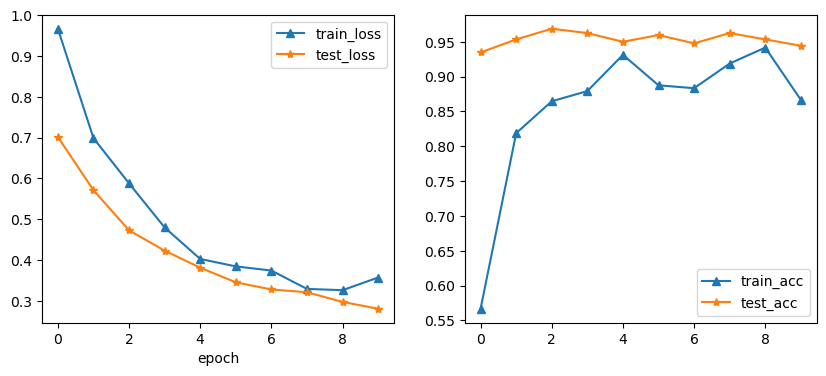

In [11]:
# visualize train and test loss and accuracy
utils.plot_loss_acc(results=results)

In [12]:
# save trained model
saved_model_path = utils.save_model(
    model=model,
    model_dir="models",
    model_name_grid=[model.name]
)

[INFO] creating folder to save model EfficientNet_B2...


In [13]:
# model statistic
from pathlib import Path

# size
model_size = Path(saved_model_path).stat().st_size // (1024*1024)

# number of parameters
num_model_params = sum(torch.numel(para) for para in model.parameters())

model_results = {
    "test_loss": results["test_loss"][-1],
    "test_acc": results["test_acc"][-1],
    "model_size (MB)": model_size,
    "num_params": num_model_params
}

model_results

{'test_loss': 0.28057227432727816,
 'test_acc': 0.9443181818181818,
 'model_size (MB)': 29,
 'num_params': 7705221}

# launch a local gradio
* import gradio
* create effnetb2
* load stat dict from file
* send the trained model to cpu
* create a predict function returning a tuple of:
  * a dictionary of prediction probability
  * prediction wall time
* create gradio interface
* launch local gradio

In [14]:
# import gradio
try:
    import gradio as gr
except:
    !pip install -q gradio
    import gradio as gr

In [15]:
# create a pretrained EfficientNetB2
model, model_transforms = models.create_effnet(effnet_version=2)

# send model to CPU when using free gradio
model.to("cpu")
next(iter(model.parameters())).device

[INFO] creating EfficientNet_B2...


device(type='cpu')

In [16]:
# load stat dict from file
model.load_state_dict(torch.load(
    f=saved_model_path,
    map_location=torch.device("cpu")
))

<All keys matched successfully>

In [17]:
from typing import Tuple, Dict
from timeit import default_timer as timer
from PIL import Image

def predict(img: Image)->Tuple[Dict,float]:
    """predict the food name probability from a list of class names
    Args:
        img: PIL image
    Return:
        Tuple[Dict, float]
            Dict: dictionary of food name probability
            float: wall time of the food name prediction
    """

    # start the timer
    start_time = timer()
    
    # transform PIL image to torch tensor, add batch dimension
    img = model_transforms(img).unsqueeze(dim=0)

    # switch model to evaluation mode
    model.eval()
    with torch.inference_mode():
        # food name probability prediction
        pred_probs = torch.softmax(model(img), dim=1)

    # assign prediction probability to a result dictionary
    pred_probs_dict = {
        class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))
    }

    # prediction wall time
    pred_wtime = timer() - start_time

    # return probability dictionary and wall time
    return pred_probs_dict, pred_wtime


# test the predict function
import random
from PIL import Image

random_path = random.choice(list(image_path_20.glob("*/*/*")))
img = Image.open(random_path)
predict(img)

({'pizza': 0.9633996486663818,
  'steak': 0.019526049494743347,
  'sushi': 0.017074353992938995},
 0.06854584999382496)

In [18]:
# create a list of examples
example_list = random.sample(list(image_path_20.glob("*/*/*")),3)

In [19]:
demo = gr.Interface(
    fn = predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=3, label="Predictions"),
        gr.Number(label="prediction time (s)")
    ],
    title="foodvisionmini",
    description="transfer learning using pretrained EfficientNetB2",
    examples=example_list
)

demo.launch(
    debug=True,
    share=True
)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://1179b0397f5cdb88e2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1179b0397f5cdb88e2.gradio.live


# create a gradio app for torchvision mini
* upload:
  * saved model
  * modules from sources
  * three examples
  * requirements.txt
  * app.py that start the app

In [20]:
# copy three random images from test folder to examples
import shutil

# create new examples/
example_dir = Path("examples")
if example_dir.is_dir():
    shutil.rmtree(example_dir)
example_dir.mkdir(parents=True, exist_ok=True)


# deep copy 3 test images to examples/
example_list = []
for example in random.sample(list(test_dir.glob("*/*")), 3):
    shutil.copy2(src=example, dst=example_dir)
    ex = [str(example_dir / example.name)]
    example_list.append(ex)

example_list

[['examples/771336.jpg'], ['examples/3401466.jpg'], ['examples/167716.jpg']]

In [21]:
%%writefile app.py
from typing import Tuple, Dict
import gradio as gr
from sources import models
from timeit import default_timer as timer
from PIL import Image

# Setup class names
class_names = ["pizza", "steak", "sushi"]

# create a pretrained EfficientNetB2 model
model, model_transforms = models.create_effnet(
    effnet_version=2,
    device=torch.device("cpu")
)

# load model state dict
model.load_state_dict(torch.load(
    f="models/EfficientNet_B2.pth",
    map_location=torch.device("cpu")
))


def predict(img: Image)->Tuple[Dict,float]:
    """predict the food name probability from a list of class names
    Args:
        img: PIL image
    Return:
        Tuple[Dict, float]
            Dict: dictionary of food name probability
            float: wall time of the food name prediction
    """

    # start the timer
    start_time = timer()
    
    # transform PIL image to torch tensor, add batch dimension
    img = model_transforms(img).unsqueeze(dim=0)

    # switch model to evaluation mode
    model.eval()
    with torch.inference_mode():
        # food name probability prediction
        pred_probs = torch.softmax(model(img), dim=1)

    # assign prediction probability to a result dictionary
    pred_probs_dict = {
        class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))
    }

    # prediction wall time
    pred_wtime = timer() - start_time

    # return probability dictionary and wall time
    return pred_probs_dict, pred_wtime

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=3, label="Predictions"),
        gr.Number(label="Prediction time (s)")
    ],
    examples=example_list
)

demo.launch()

Overwriting app.py


In [22]:
torch.__version__

'2.0.1+cu118'

In [23]:
torchvision.__version__

'0.15.2+cu118'

In [24]:
gr.__version__

'4.1.2'

In [25]:
%%writefile requirements.txt
torch==2.0.1
torchvision==0.15.2
gradio==4.1.2

Overwriting requirements.txt


# app on hugging face space
https://huggingface.co/spaces/buupq/foodvisionmini